In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
from tqdm import tqdm

folder_dir = "./individual_stocks_5yr"
exclude_files = []

In [2]:
# !unzip "/content/individual_stocks_5yr.zip" -d "/content"
folder_dir = "/content/individual_stocks_5yr/individual_stocks_5yr"

In [3]:
def check_date(folder_dir):
    count = 0
    exclude = []
    for file in os.listdir(folder_dir):
        if file in ['.DS_Store']:
            continue
        dir = os.path.join(folder_dir, file)
        df = pd.read_csv(dir)
        file_start_date = df['date'][df.index[0]]
        file_end_date = df['date'][df.index[-1]]

        if file_start_date not in ['2013-02-08']:
            # print('start date diff: {}'.format(file))
            exclude.append(file)
            count += 1
        elif file_end_date not in ['2018-02-07']:
            # print('end date diff: {}'.format(file))
            exclude.append(file)
            count += 1
        elif df.shape[0] != 1259:
            # print('missing date data: {}'.format(file))
            exclude.append(file)
            count += 1
    return np.array(exclude).reshape(-1,1)

In [4]:
def get_stocks(folder_dir):
    #stocks = np.zeros((476, 1259))
    stocks = np.zeros((470, 1259))
    prices = np.zeros((470, 1259))
    stock_names = []
    index = 0
    exclude_files = check_date(folder_dir)
    for file in sorted(os.listdir(folder_dir)):
        if file in exclude_files:
            continue
        if file in ['.DS_Store']:
            continue
        dir = os.path.join(folder_dir, file)
        df = pd.read_csv(dir)
        file_start_date = df['date'][df.index[0]]
        file_end_date = df['date'][df.index[-1]]
        
        if file_start_date == '2013-02-08' and file_end_date == '2018-02-07' and len(df) == 1259:
            # change = (df['close'] - df['open']) / df['open']
            change = df['close'] - df['open']
            change = np.array(change)
            change[np.isnan(change)] = 0
            stocks[index] = change
            prices[index] = np.array(df['open'])
            stock_name = file.split('_')[0]
            stock_names.append(stock_name)
            index += 1
    return (stocks, stock_names, prices)       

In [5]:
(stocks, stock_names, prices) = get_stocks(folder_dir)
name_index = {}
for i in range(len(stock_names)):
    name_index[stock_names[i]] = i
normalizer = Normalizer()
normalized_stocks = normalizer.fit_transform(stocks)

In [6]:
#Elbow method
distortions = []
pbar = tqdm(range(1, 101))
for k in pbar:
    total = 0
    for i in range(5):
        model = KMeans(n_clusters = k)
        model.fit(normalized_stocks)
        total += model.inertia_
    distortion = total / 5
    distortions.append(distortion)


100%|██████████| 100/100 [09:51<00:00,  5.92s/it]


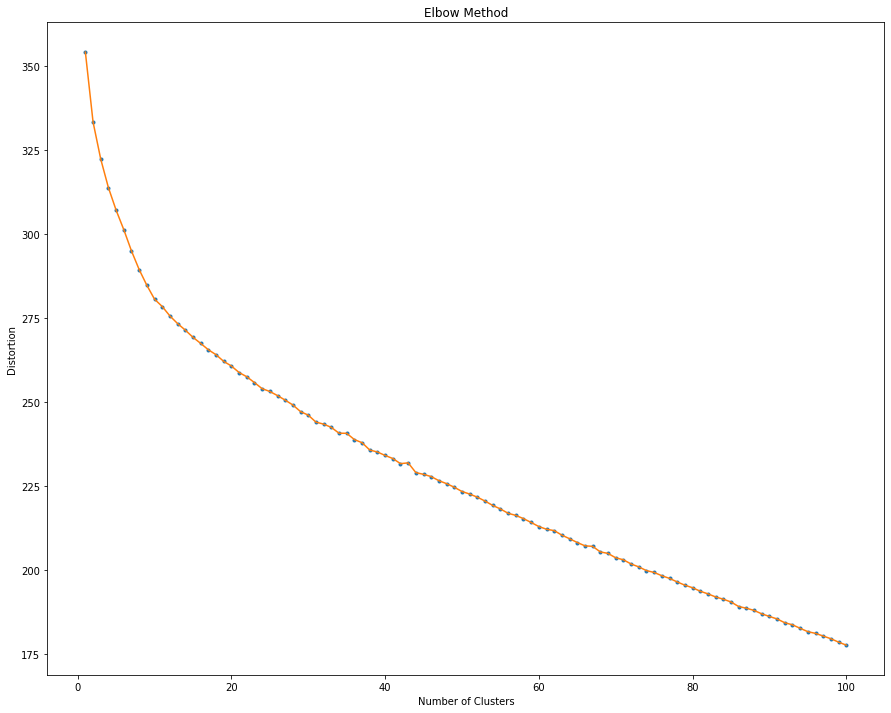

In [7]:
plt.figure(figsize=(15,12))
plt.xlabel("Number of Clusters")
plt.ylabel("Distortion")
plt.title("Elbow Method")
#plt.plot(distortions)
plt.plot(range(1,101), distortions[:100], '.')
plt.plot(range(1,101), distortions[:100])
plt.show()

In [8]:
model = KMeans(n_clusters = 10)
model.fit(normalized_stocks)
labels = model.predict(normalized_stocks)

In [9]:
score = silhouette_score(normalized_stocks, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.058669790005098615


In [10]:
clusters = {}
for i in range(len(labels)):
    stock_name = stock_names[i]
    cluster = labels[i]
    if cluster in clusters:
        clusters[cluster].append(stock_name)
    else:
        clusters[cluster] = [stock_name]
for cluster in sorted(clusters.keys()):
    print(str(cluster + 1) + ':', clusters[cluster])

1: ['AAP', 'AZO', 'BBY', 'CHTR', 'CMG', 'COST', 'DG', 'DLTR', 'DRI', 'FL', 'GPS', 'HBI', 'HD', 'JWN', 'KORS', 'KR', 'KSS', 'LB', 'LKQ', 'LOW', 'M', 'NKE', 'ORLY', 'PVH', 'RL', 'ROST', 'SBUX', 'SIG', 'TGT', 'TIF', 'TJX', 'TPR', 'TSCO', 'UAA', 'ULTA', 'VFC']
2: ['BF.B', 'CAG', 'CHD', 'CLX', 'CL', 'CPB', 'DPS', 'EL', 'GIS', 'HRL', 'HSY', 'KMB', 'KO', 'K', 'MDLZ', 'MKC', 'MNST', 'MO', 'PEP', 'PG', 'PM', 'SJM', 'SYY', 'TAP', 'TSN', 'T', 'VZ', 'WMT']
3: ['AAL', 'ADM', 'ADP', 'ADS', 'ALK', 'AME', 'ANDV', 'AOS', 'APD', 'AVY', 'AYI', 'BA', 'BLL', 'BWA', 'CAT', 'CBG', 'CBS', 'CHRW', 'CMCSA', 'CMI', 'COL', 'CSX', 'CTAS', 'CTL', 'DAL', 'DE', 'DHI', 'DISCA', 'DISCK', 'DISH', 'DIS', 'DOV', 'ECL', 'EMN', 'EMR', 'ETN', 'EXPD', 'FAST', 'FBHS', 'FDX', 'FLIR', 'FLR', 'FLS', 'FMC', 'F', 'GD', 'GE', 'GLW', 'GM', 'GPC', 'GRMN', 'GT', 'GWW', 'HAS', 'HII', 'HOG', 'HON', 'HRB', 'HST', 'IBM', 'IFF', 'IPG', 'IP', 'IR', 'ITW', 'JBHT', 'JCI', 'JEC', 'KMX', 'KSU', 'LEG', 'LEN', 'LLL', 'LMT', 'LUV', 'MAR', 'MAS', 'M

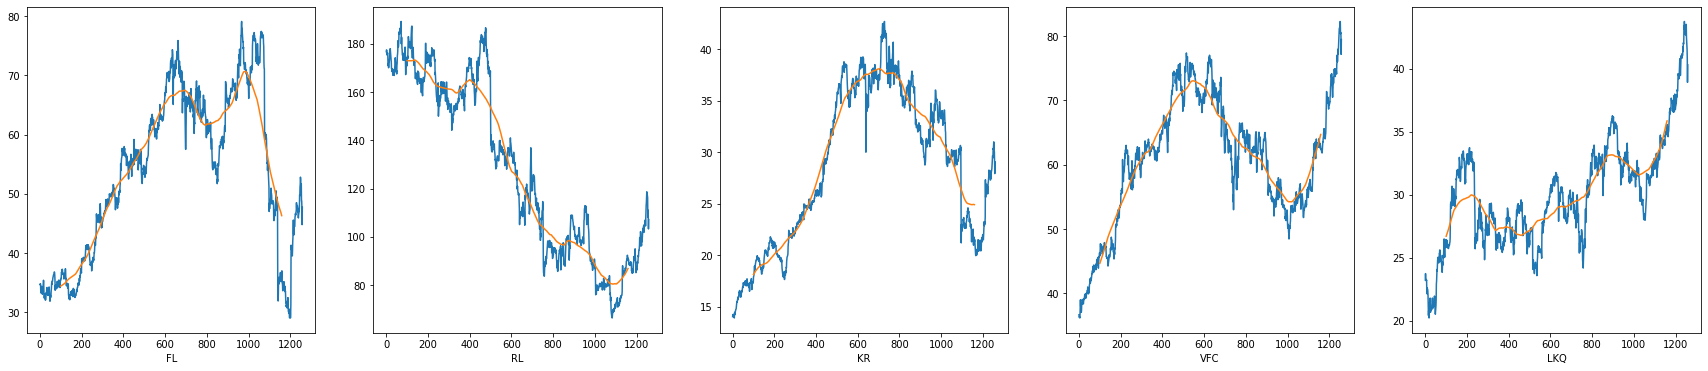

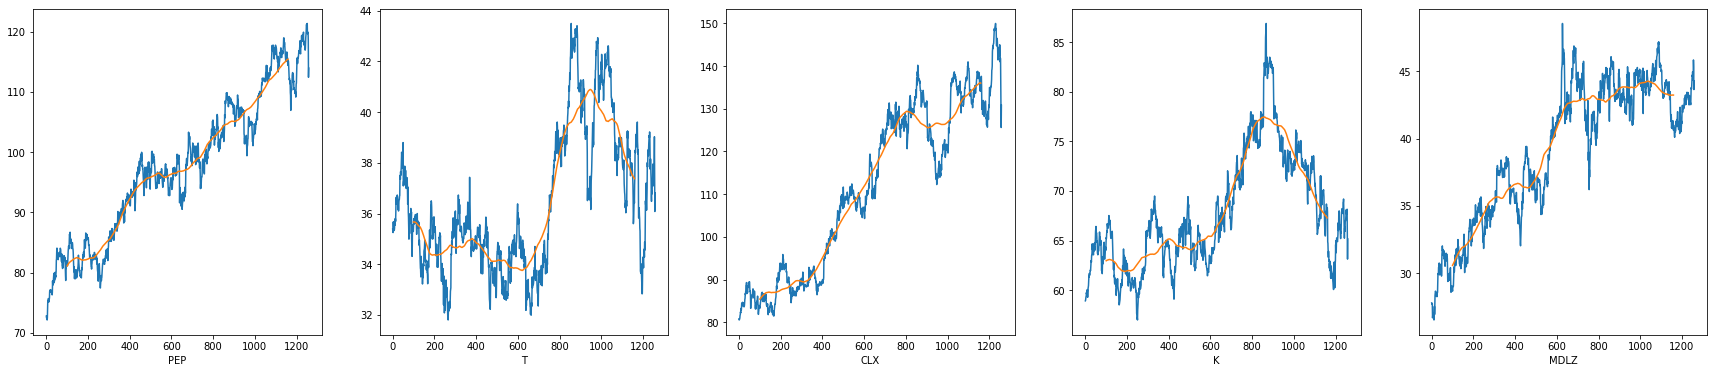

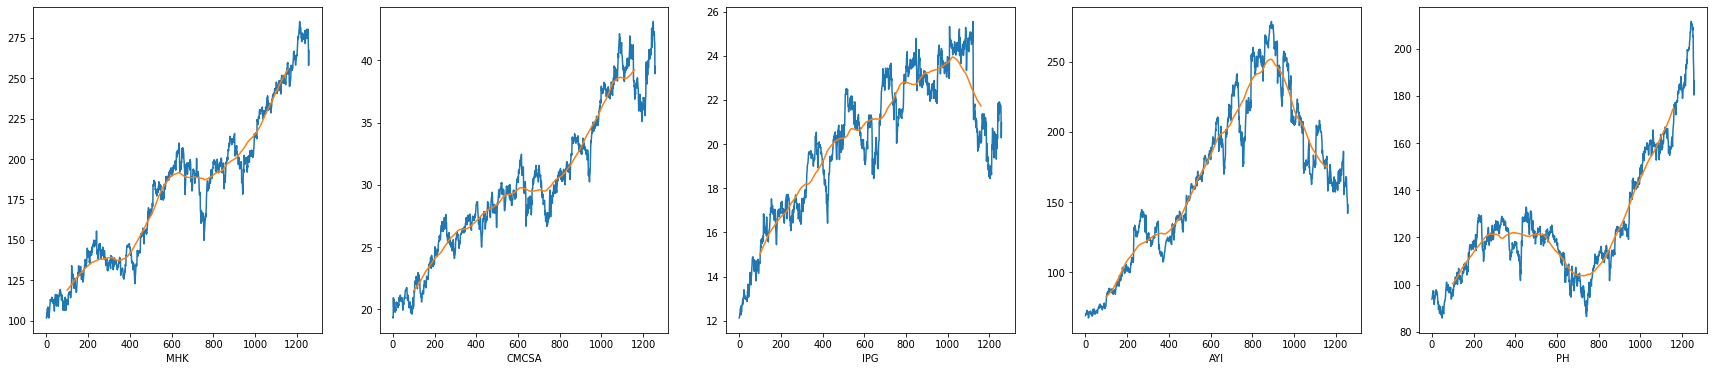

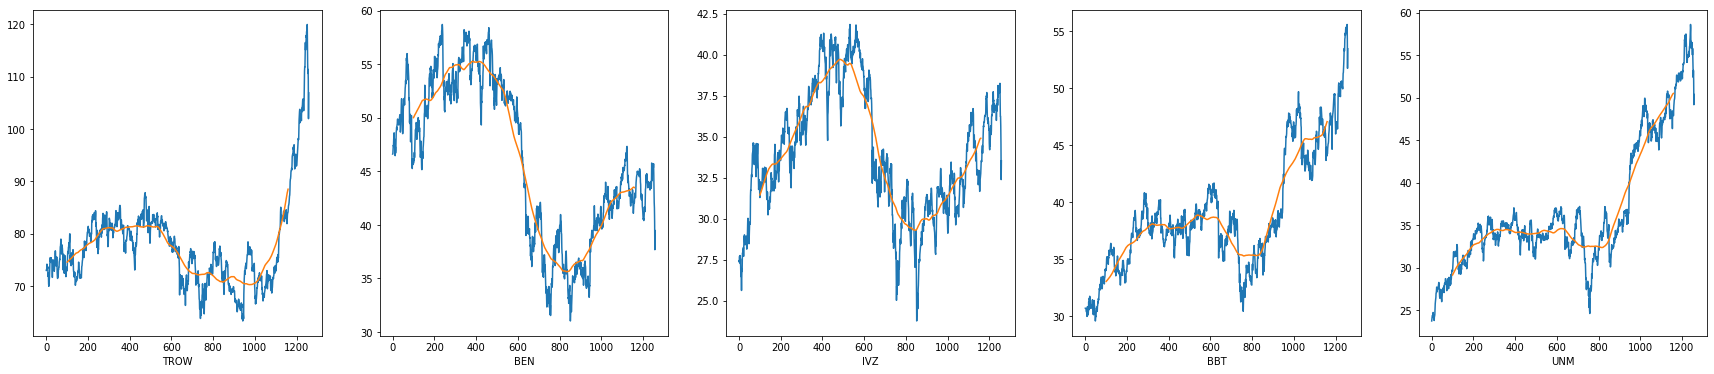

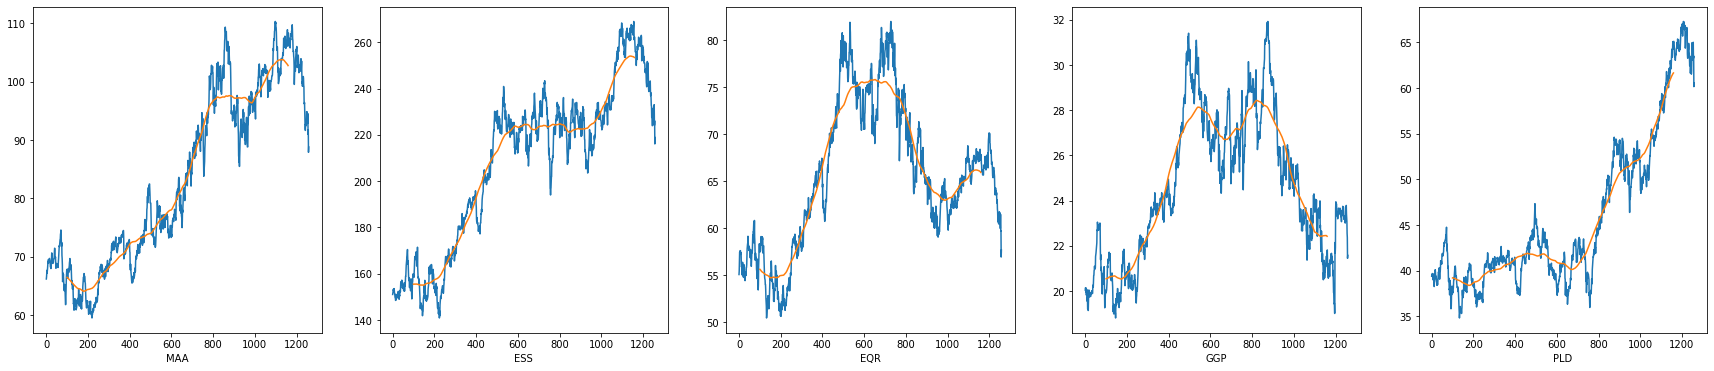

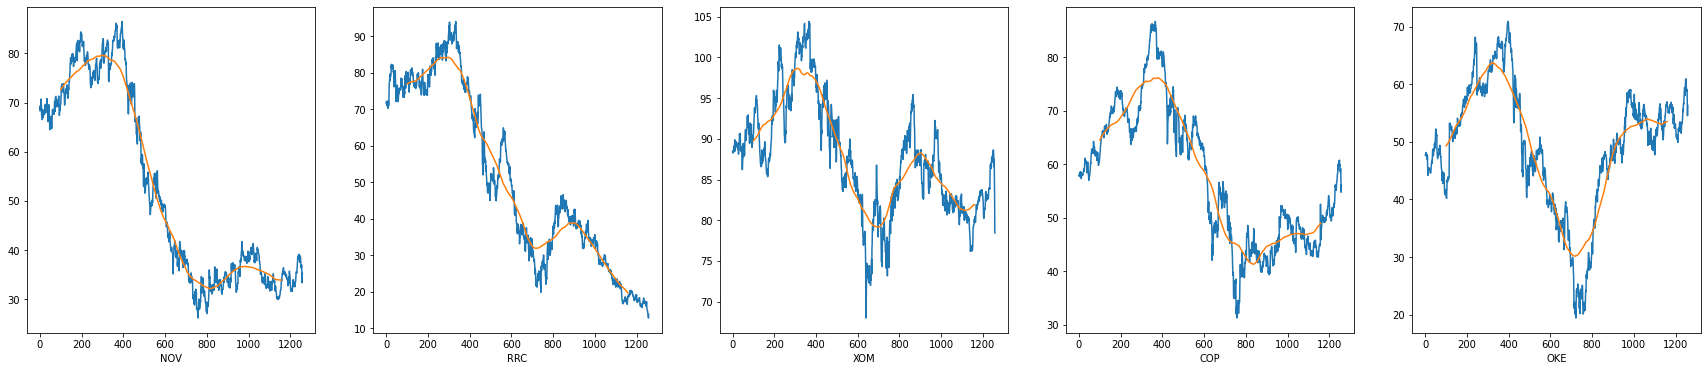

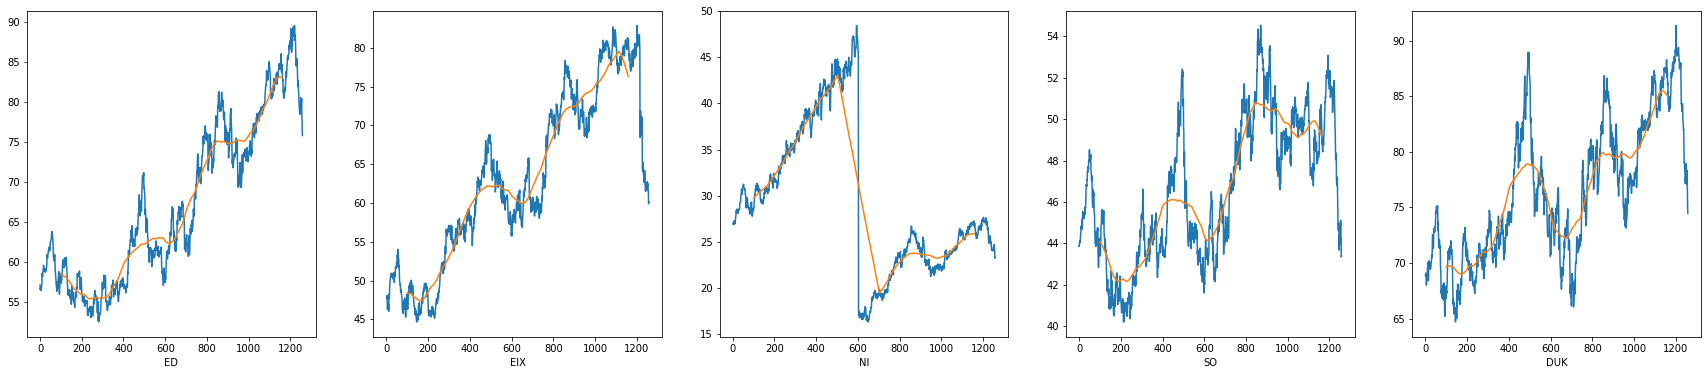

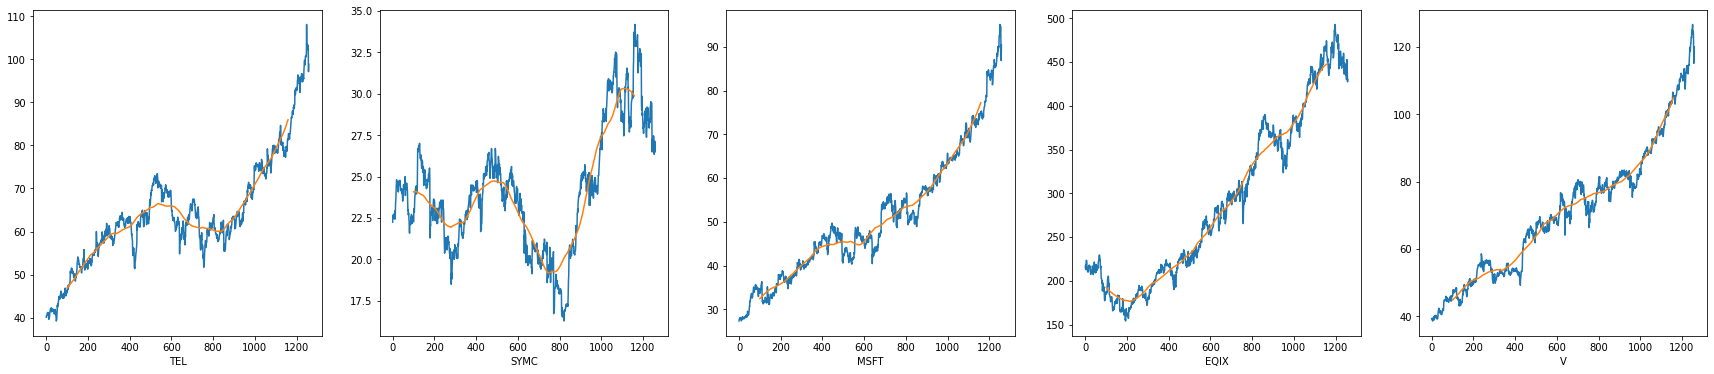

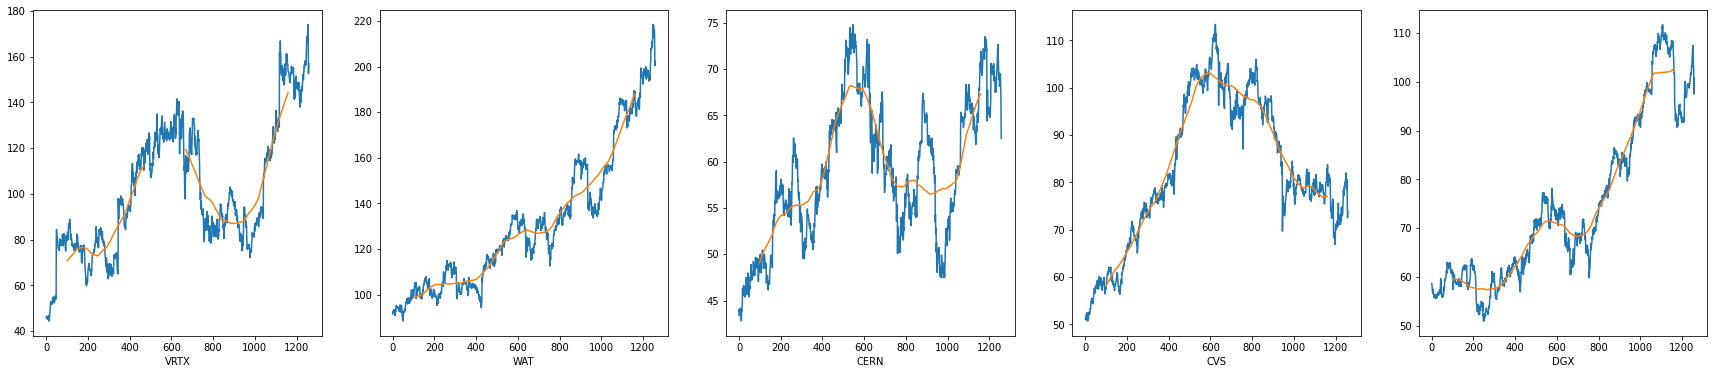

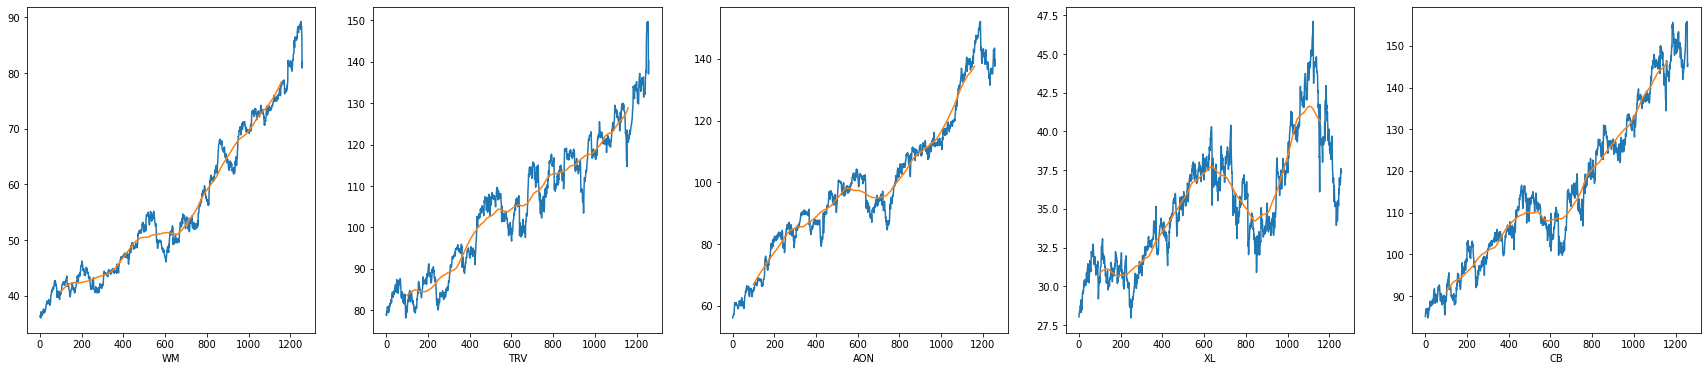

In [11]:
from matplotlib.pyplot import figure
for cluster in sorted(clusters.keys()):
    num_stocks = 5
    random_stocks = np.random.choice(clusters[cluster], size=num_stocks, replace=False)
    figure(figsize=(30,6))
    for i in range(num_stocks):
        stock_name = random_stocks[i]
        stock_index = name_index[stock_name]
        stock_price = prices[stock_index]

        plt.subplot(1, num_stocks, i + 1)
        plt.xlabel(stock_name)
        plt.plot(stock_price)

        # Apply Moving Average
        moving_avg = []
        window_size = 200
        for i in range(len(stock_price) - window_size + 1):
            window = stock_price[i : i+window_size]
            avg = np.sum(window) / window_size
            moving_avg.append(avg)
        x = np.arange(len(stock_price) - window_size + 1) + window_size/2
        plt.plot(x, moving_avg, label=window_size)

    plt.show()

In [12]:
"""
PCA K-Mean Visulization
"""
from sklearn.decomposition import PCA

(stocks, stock_names, prices) = get_stocks(folder_dir)
normalizer = Normalizer()
normalized_stocks = normalizer.fit_transform(stocks)
print("shape for original data:", normalized_stocks.shape)

# PCA
reduce_feature = PCA(n_components = 2).fit_transform(normalized_stocks)
print("shape after PCA with 2 components:", reduce_feature.shape)

# K-Means with reduced feature data
model_pca = KMeans(n_clusters = 10)
model_pca.fit(reduce_feature)
labels = model_pca.predict(reduce_feature)

# silhouette score
score = silhouette_score(reduce_feature, labels)
print("Silhouette Score:", score)

# Companies in each label
df = pd.DataFrame({'labels': labels, 'companies': stock_names})
print(df[df['labels']==0])
print(df[df['labels']==1])
print(df[df['labels']==2])
print(df[df['labels']==3])
print(df[df['labels']==4])
print(df[df['labels']==5])
print(df[df['labels']==6])
print(df[df['labels']==7])
print(df[df['labels']==8])
print(df[df['labels']==9])


shape for original data: (470, 1259)
shape after PCA with 2 components: (470, 2)
Silhouette Score: 0.3953807482199907
     labels companies
15        0       AES
64        0      BF.B
68        0       BLL
73        0       CAG
87        0       CHD
114       0       CTL
148       0        EL
229       0       IRM
280       0      MDLZ
308       0       NEM
316       0       NRG
338       0        PG
373       0       RSG
375       0      SBAC
382       0       SJM
384       0       SLG
391       0      SRCL
401       0       SYY
402       0       TAP
413       0       TRV
415       0       TSN
420       0         T
443       0        VZ
452       0       WMT
453       0        WM
457       0        WY
     labels companies
2         1       AAP
9         1       ADM
17        1       AFL
21        1       AIZ
24        1       ALB
..      ...       ...
450       1       WHR
454       1        WU
455       1      WYNN
461       1        XL
464       1       XRX

[86 rows x 2 columns]
 

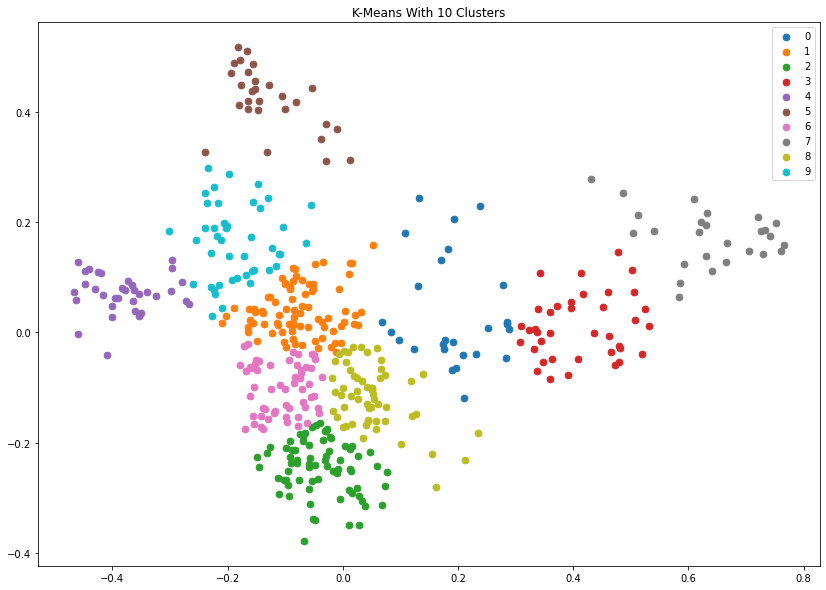

In [13]:
# Plot clusters
# Note, plot will change after running k means each time
plt.figure(figsize=(14,10))
legend_lis = []
for i in range(10):
    legend_lis.append(i)
    label_i = reduce_feature[labels == i]
    plt.scatter(label_i[:,0], label_i[:,1], s=45)
plt.legend(legend_lis)
plt.title('K-Means With 10 Clusters')
plt.show()

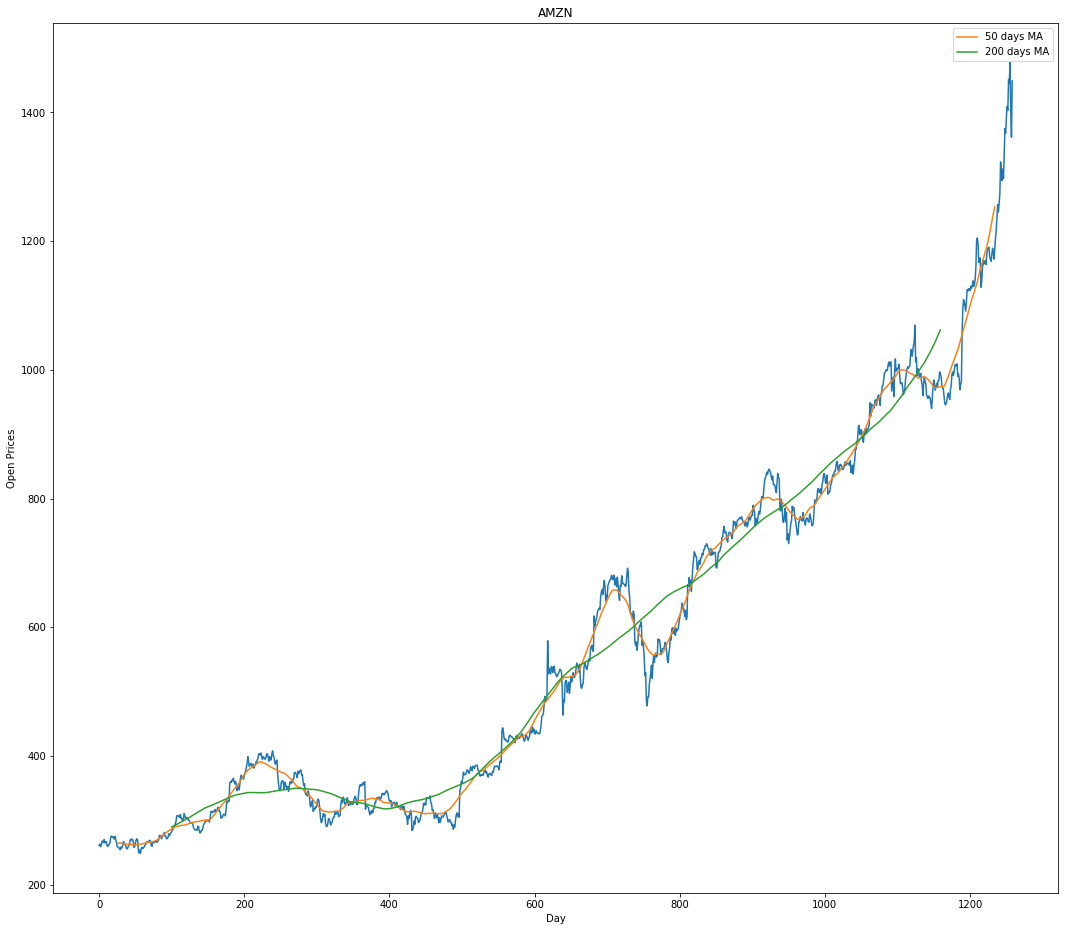

In [14]:
"""
Plot for one stock, with moving average applied
"""
folder_dir = "/content/individual_stocks_5yr/individual_stocks_5yr"

stocks_change, stock_names, open_prices = get_stocks(folder_dir)

index = stock_names.index('AMZN')
change = stocks_change[index,:]
prices = open_prices[index,:]
plt.figure(figsize=(18,16))
plt.plot(prices)

for window_size in [50,200]:
    moving_avg = []
    for i in range(len(prices) - window_size + 1):
        window = prices[i : i+window_size]
        avg = np.sum(window) / window_size
        moving_avg.append(avg)
    x = np.arange(len(prices) - window_size + 1) + window_size/2
    plt.plot(x, moving_avg, label="{} days MA".format(window_size))

plt.legend()
plt.title('{}'.format(stock_names[index]))
plt.ylabel('Open Prices')
plt.xlabel('Day')
plt.show()


Text(0.5, 0, 'date')

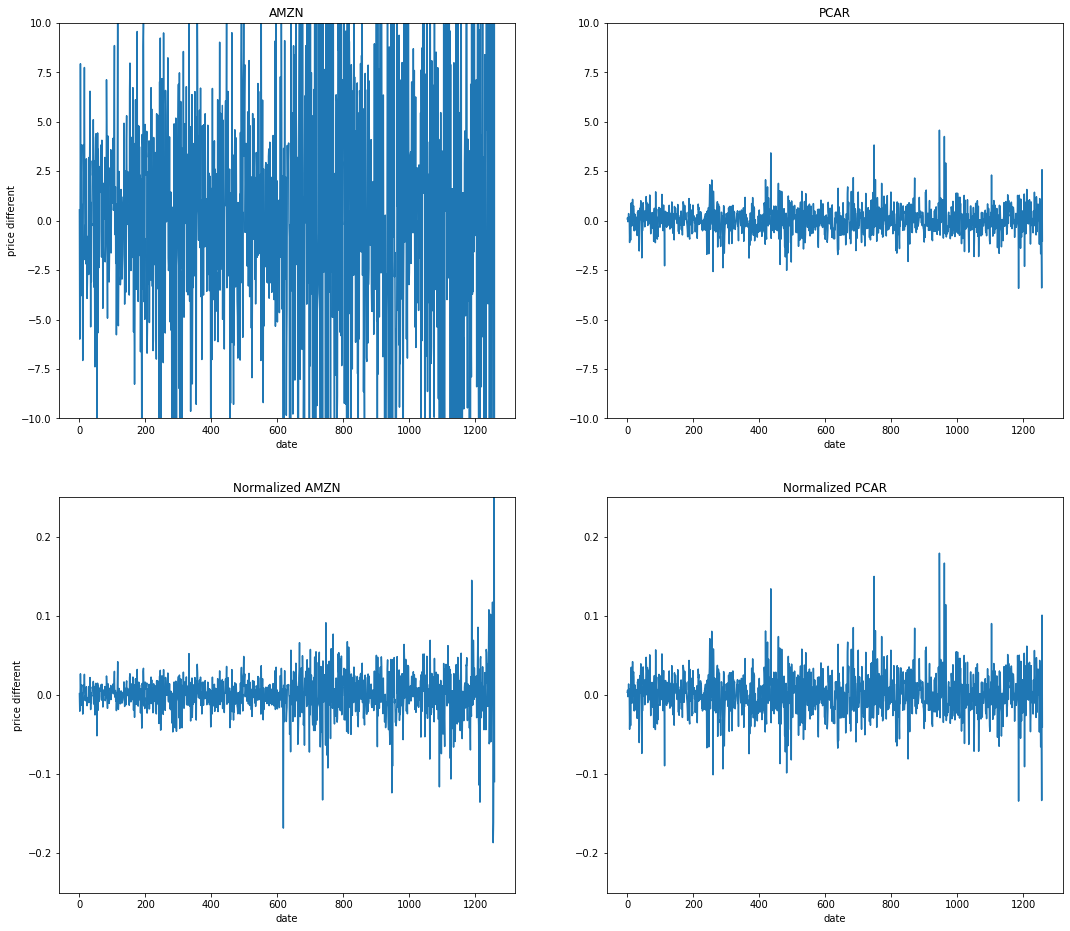

In [15]:
"""
Plot for normalization
"""

folder_dir = "/content/individual_stocks_5yr/individual_stocks_5yr"
stocks_change, stock_names, open_prices = get_stocks(folder_dir)

index_amzn = stock_names.index('AMZN')
index = stock_names.index('PCAR')
change_amzn = stocks_change[index_amzn,:]
change = stocks_change[index,:]
# print(change)
# print(change.max(), change.min(), change.mean())

change_arr_amzn = np.array(change_amzn).reshape(1,-1)
change_arr = np.array(change).reshape(1,-1)

normalizer = Normalizer()
normalized_change_amzn = normalizer.fit_transform(change_arr_amzn)[0]
normalized_change = normalizer.fit_transform(change_arr)[0]
# print(normalized_change)
# print(normalized_change.max(), normalized_change.min(), normalized_change.mean())

plt.figure(figsize=(18,16))
plt.subplot(2,2,1)
plt.ylim([-10, 10])
plt.plot(change_amzn)
plt.title('AMZN')
plt.ylabel('price different')
plt.xlabel('date')

plt.subplot(2,2,2)
plt.ylim([-10,10])
plt.plot(change)
plt.title('PCAR')
plt.xlabel('date')

plt.subplot(2,2,3)
plt.ylim([-0.25, 0.25])
plt.plot(normalized_change_amzn)
plt.title('Normalized AMZN')
plt.ylabel('price different')
plt.xlabel('date')

plt.subplot(2,2,4)
plt.ylim([-0.25, 0.25])
plt.plot(normalized_change)
plt.title('Normalized PCAR')
plt.xlabel('date')